In [2]:
import numpy as np
import pandahouse
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
%matplotlib inline

In [5]:
def get_linearized_likes(df, control, treatment):
    '''
    Выбирает из датафейма нужные группы и рассчитывает для них линеаризированные лайки
    
    Параметры
    ---------
    df: датафрейм
    control: номер контрольной группы
    treatment: номер группы, получающей новую функциональность

    Функция возвращает датарфрейм с дополнительной колонкой для линеаризованных лайков
    '''
    
    # Создаем датафрейм с нужными группами
    new_df = df[(df.exp_group == control) | (df.exp_group == treatment)].copy()
    # Вычисляем ctr контрольной группы
    ctr_control = new_df.loc[new_df.exp_group == control, 'likes'].sum() / new_df.loc[new_df.exp_group == control, 'views'].sum()
    # Вычисляем и возвращаем линеаризованные лайки согласно формуле 𝑙𝑖𝑛𝑒𝑎𝑟𝑖𝑧𝑒𝑑_𝑙𝑖𝑘𝑒𝑠=𝑙𝑖𝑘𝑒𝑠−𝐶𝑇𝑅𝑐𝑜𝑛𝑡𝑟𝑜𝑙∗𝑣𝑖𝑒𝑤𝑠
    return new_df.assign(linearized_likes = lambda x: x['likes'] - ctr_control * x['views'])

In [7]:
def compare_tests(df, control, treatment):
    ''' 
    Сравнивает обычный t-test и t-test с линеаризированными лайками
    
    Параметры
    ---------
    df: датафрейм
    control: номер контрольной группы
    treatment: номер группы, получающей новую функциональность

    Функция возвращает None
    '''
    
    # Получаем датафрейм с линеаризованными лайками
    group = get_linearized_likes(df, control, treatment)

    # Проводим обычный t-test и t-test с линеаризированными лайками
    t_test_result = stats.ttest_ind(df[df.exp_group == control].ctr,
                                    df[df.exp_group == treatment].ctr,
                                    equal_var=False)

    linearized_t_test_result = stats.ttest_ind(group[group.exp_group == control].linearized_likes,
                                               group[group.exp_group == treatment].linearized_likes,
                                               equal_var=False)

    # Выводим результат тестов
    print(f't-test: statistics = {t_test_result[0]}, p-value = {t_test_result[1]}')
    print(f'linearized-t-test: statistics = {linearized_t_test_result[0]}, p-value = {linearized_t_test_result[1]}')
    
    # Построим графики для ctr и линеаризированных лайков, чтобы увидеть как они отличаются
    fig, (ax1, ax2) = plt.subplots(2)
    sns.set(rc={'figure.figsize':(11.7,8.27)})
    sns.histplot(group[group.exp_group == control].linearized_likes, color='r', alpha=0.5, ax=ax1);
    sns.histplot(group[group.exp_group == treatment].linearized_likes, color='b', alpha=0.5, ax=ax1);
    sns.histplot(df[df.exp_group == control].ctr, color='r', alpha=0.5, ax=ax2);
    sns.histplot(df[df.exp_group == treatment].ctr, color='b', alpha=0.5, ax=ax2);

In [8]:
connection = {
    'host': 'https://clickhouse.lab.karpov.courses',
    'password': 'dpo_python_2020',
    'user': 'student',
    'database': 'simulator_20230120'
}

query = """
SELECT exp_group,
       user_id,
       countIf(action = 'view') views,
       countIf(action = 'like') likes,
       likes / views ctr
  FROM {db}.feed_actions
 WHERE toDate(time) BETWEEN '2023-01-01' AND '2023-01-07'
 GROUP BY exp_group,
          user_id
"""

df = pandahouse.read_clickhouse(query, connection=connection)

# Проверим, что все загрузилось как надо
print(df.head(5))

   exp_group  user_id  views  likes       ctr
0          3   115383     30      9  0.300000
1          1    18392     32      7  0.218750
2          3   123580     48     13  0.270833
3          2   131473    134     14  0.104478
4          4   107323     31      5  0.161290


<h4>Сравним результаты обычного t-test и линеаризованных лайков для групп 0 и 3</h4>

t-test: statistics = -13.896870721904069, p-value = 1.055849414662529e-43
linearized-t-test: statistics = -15.214995460903827, p-value = 5.4914249479690016e-52


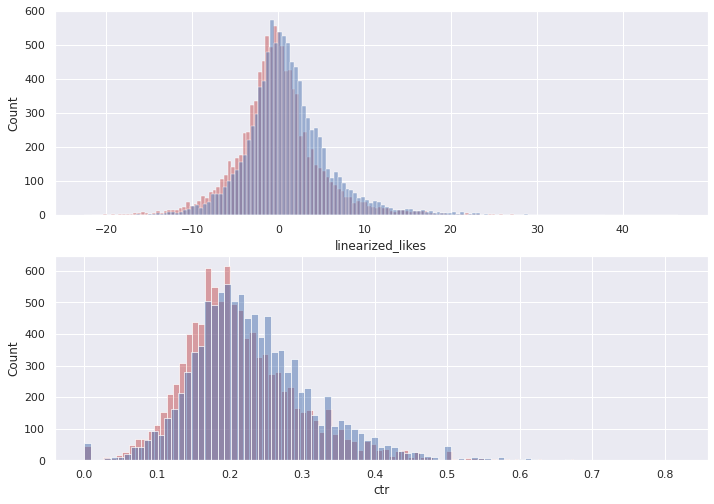

In [10]:
compare_tests(df, 0, 3)

<h2>Вывод</h2>
<p>Оба теста видят различия между группами. p-value по метрике линеаризованных лайков стало меньше</p>

<h4>Сравним результаты обычного t-test и линеаризованных лайков для групп 1 и 2</h4>

t-test: statistics = 0.7094392041270485, p-value = 0.4780623130874935
linearized-t-test: statistics = 6.122579994775974, p-value = 9.439432187037644e-10


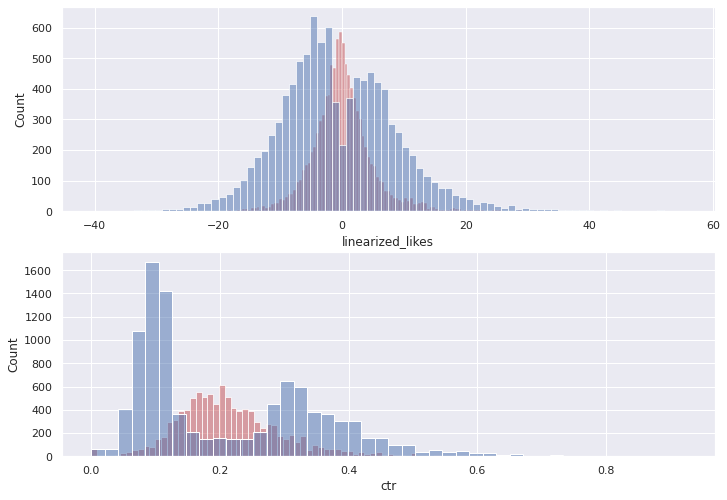

In [11]:
compare_tests(df, 1, 2)

<h2>Вывод</h2>
<p>Обычный t-test не увидел разницы между группами в отличие от t-test по метрике линеаризованных лайков.
p-value по метрике линеаризованных лайков стало меньше</p>